# Loading datasets

In [3]:
import os

spam_emails_path = os.path.join("spamassassin-public-corpus", "spam")
ham_emails_path = os.path.join("spamassassin-public-corpus", "ham")
labeled_file_directories = [(spam_emails_path, 0), (ham_emails_path, 1)]

# Load raw email texts and labels (0 = spam, 1 = ham) from filesystem, handling encoding and read errors

In [4]:
def load_emails_from_directory(directory_path, label):
    email_texts = []
    labels = []
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        try:
            with open(file_path, "r", encoding="latin1") as f:
                content = f.read().replace("\n", " ")
                email_texts.append(content)
                labels.append(label)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return email_texts, labels

email_corpus = []
labels = []

for path, label in labeled_file_directories:
    emails, lbls = load_emails_from_directory(path, label)
    email_corpus.extend(emails)
    labels.extend(lbls)


# Split email data into training and test sets (80/20) with fixed random seed

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    email_corpus, labels, test_size=0.2, random_state=11
)

# Create and train a text classification pipeline: HashingVectorizer → TF-IDF → balanced Decision Tree

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn import tree

nlp_followed_by_dt = Pipeline(
    [
        ("vect", HashingVectorizer(input="content", ngram_range=(1, 3))),
        ("tfidf", TfidfTransformer(use_idf=True,)),
        ("dt", tree.DecisionTreeClassifier(class_weight="balanced")),
    ]
)
nlp_followed_by_dt.fit(X_train, y_train)

Pipeline(steps=[('vect', HashingVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('dt', DecisionTreeClassifier(class_weight='balanced'))])

# Print training accuracy of the Decision Tree pipeline

In [7]:
print(nlp_followed_by_dt.score(X_train, y_train))

1.0


# Predict on test set and print accuracy and confusion matrix to evaluate generalization

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_pred = nlp_followed_by_dt.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

0.9886104783599089
[[296   3]
 [  2 138]]


# Classification Report 

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       299
        spam       0.98      0.99      0.98       140

    accuracy                           0.99       439
   macro avg       0.99      0.99      0.99       439
weighted avg       0.99      0.99      0.99       439



The model achieved high precision and recall across both classes, with a weighted F1-score of 0.99. This indicates a strong ability to both detect spam and avoid false positives. Only 3 ham messages were incorrectly flagged, and just 2 spam messages slipped through

# Confusion Matrix

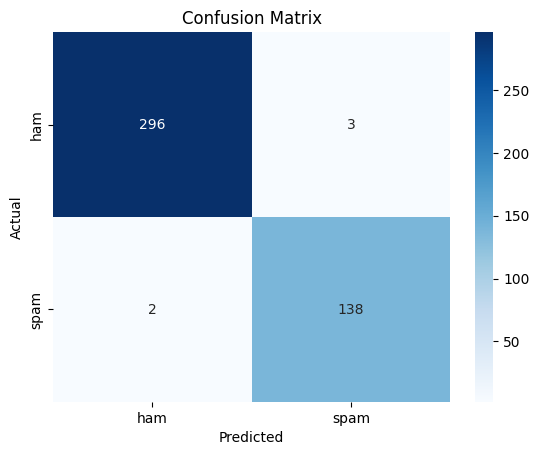

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# MultinomialNB

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), stop_words='english')),
    ('nb', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
y_nb_pred = nb_pipeline.predict(X_test)


              precision    recall  f1-score   support

         ham       0.96      0.98      0.97       299
        spam       0.96      0.91      0.94       140

    accuracy                           0.96       439
   macro avg       0.96      0.95      0.95       439
weighted avg       0.96      0.96      0.96       439



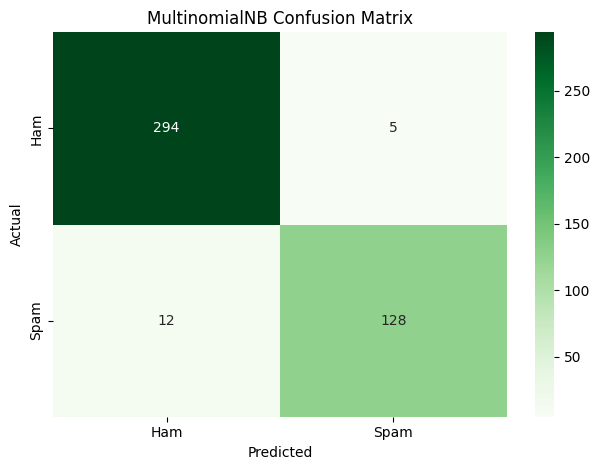

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_nb_pred, target_names=["ham", "spam"]))
sns.heatmap(confusion_matrix(y_test, y_nb_pred), annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('MultinomialNB Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

While the Decision Tree pipeline achieved higher accuracy (99%) and lower false negative rate, Multinomial Naive Bayes performed competitively with 96% accuracy using a simpler model. However, Naive Bayes allowed 12 spam emails through, compared to only 2 in the tree-based model — which may be a critical difference depending on the application’s tolerance for spam leakage.

# Logistic Regression vs Random Forest

In [14]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), stop_words='english')),
    ('lr', LogisticRegression(max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
y_lr_pred = lr_pipeline.predict(X_test)


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), stop_words='english')),
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
])

rf_pipeline.fit(X_train, y_train)
y_rf_pred = rf_pipeline.predict(X_test)

=== Logistic Regression ===
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       299
        spam       0.98      0.95      0.96       140

    accuracy                           0.98       439
   macro avg       0.98      0.97      0.97       439
weighted avg       0.98      0.98      0.98       439



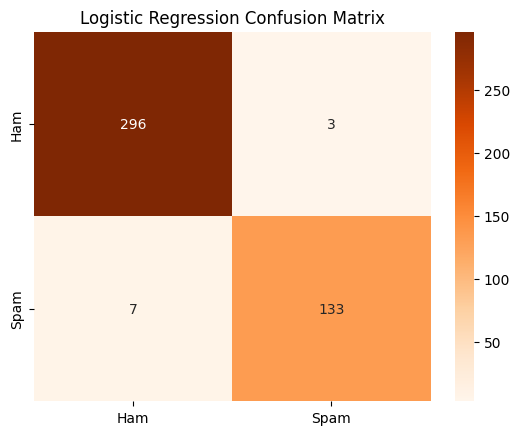

=== Random Forest ===
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       299
        spam       1.00      0.96      0.98       140

    accuracy                           0.99       439
   macro avg       0.99      0.98      0.98       439
weighted avg       0.99      0.99      0.99       439



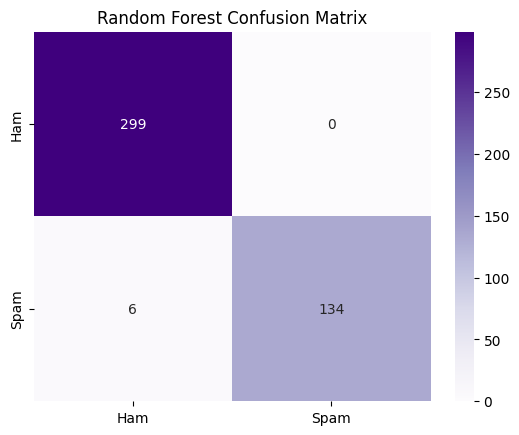

In [16]:
print("=== Logistic Regression ===")
print(classification_report(y_test, y_lr_pred, target_names=["ham", "spam"]))
sns.heatmap(confusion_matrix(y_test, y_lr_pred), annot=True, fmt='d', cmap='Oranges', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Logistic Regression Confusion Matrix')
plt.show()

print("=== Random Forest ===")
print(classification_report(y_test, y_rf_pred, target_names=["ham", "spam"]))
sns.heatmap(confusion_matrix(y_test, y_rf_pred), annot=True, fmt='d', cmap='Purples', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Random Forest Confusion Matrix')
plt.show()

After evaluating multiple classifiers, the Random Forest model demonstrated the best overall performance with 99% accuracy, perfect ham recall, and no false positives. While Logistic Regression also performed strongly, simpler models like Naive Bayes lagged slightly behind, especially in spam recall. These results confirm the effectiveness of ensemble methods for complex, real-world text classification tasks like spam filtering.

# Conclusion

## Models Evaluated

| Model                  | Accuracy | Spam Recall | Spam Precision | False Positives | False Negatives |
|-----------------------|----------|-------------|----------------|------------------|------------------|
| **Decision Tree**         | 0.99     | 0.99        | 0.98           | 3                | 2                |
| **Multinomial Naive Bayes** | 0.96     | 0.91        | 0.96           | 5                | 12               |
| **Logistic Regression**   | 0.98     | 0.95        | 0.98           | 3                | 7                |
| **Random Forest**         | 0.99     | 0.96        | 1.00           | **0**         | 5                |

---

## Key Metrics

- **Best Accuracy**: Random Forest (99%)
- **Most Balanced Classifier**: Logistic Regression
- **Fast & Lightweight**: MultinomialNB (good baseline)
- **Zero False Positives**: Random Forest (perfect ham detection)

---

## Hyperparameters Used

### **Decision Tree**
- `class_weight='balanced'` – ensures fairness across ham/spam classes
- Default depth and split settings (likely caused slight overfitting)

### **Multinomial Naive Bayes**
- All parameters default
- Assumes word counts follow multinomial distribution (ideal for text)

### **Logistic Regression**
- `max_iter=1000` – increased from default (100) to ensure convergence
- `C=1.0` (default) – inverse of regularization strength

### **Random Forest**
- `n_estimators=100` – number of trees in the forest
- `class_weight='balanced'` – adjusts for class imbalance
- Other hyperparameters at default (can be tuned for even better performance)

---

## Conclusion

> Among all tested models, **Random Forest** achieved the most balanced and accurate results, with **no false positives** and near-perfect spam detection. Although Naive Bayes and Logistic Regression offered decent performance with faster training, they lagged in recall or precision. Decision Tree showed strong results but risked overfitting. For real-world deployment, ensemble methods like Random Forest are highly recommended.